<a href="https://colab.research.google.com/github/mydmitrii/ML_development_project/blob/main/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_development_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы машинного обучения в оценке участка застройки под новое строительство

# Постановка задачи

В ходе моей работы в компании-застройщике, часто возникает потребность произвести инвестиционный анализ (Due diligence) участка, рассматриваемого к покупке застройщиком.

Данная процедура включает в себя следующие этапы:
1. Анализ конкурентов в данной локации: цена, класс жилья, наполнение проекта и т.д. SWOT-анализ
2. Построение эскиза застройки территории. В зависимости от конфигурации участка (на участке правильной формы проще получить бОльшую продаваемую площадь), ограничений участка (санитарно-защитные зоны, нормативные расстояния от проездов, парковочных мест и придомовых площадок), инсоляции (расположение домов относительно сторон света, избегая затенения друг друга) и ограничения участка по суммарной поэтажной площади наружных стен, происходит подсчет Технико-экономических показателей (ТЭП) участка
3. Построение финансовой модели с учетом ТЭП, прогнозируемой цены и расходами на строительно-монтажные работы, стоимости участка и банковского обслуживания. На основе этих данных происходит оценка инвестиционной привлекательности участка

В ходе финального проекта хочу реализовать первый этап данной процедуры. Внедрение прогнозирования цен, класса жилья для новостроек в данной локации позволит сократить время, затрачиваемое аналитиком на 1-2 рабочих дня

# Подготовка данных

В качестве исходных данных буду использовать спарсенные данные ЦИАН для новостроек. Можно использовать и готовые датасеты, но для реального применения они не годятся, т.к. быстро устаревают и не отображают ситуацию в текущий момент времени.

ЦИАН позволяет скачать объявления по поисковому запросу в формате Excel, но он ограничивает число квартир 200  квартирами при бесплатном использовании, что для построения модели недостаточно. Поэтому пришлось прибегнуть к парсингу ЦИАНа. При парсинге ЦИАН столкнулся с тем, что ЦИАН выдает максимум 1500 объявлений по каждому фильтру. Поэтому чтобы увеличить число данных парсил отдельно: студии, 1-комн. квартиры, 2-комн. квартиры, 3-комн. квартиры. Также парсил отдельно квартиры в зависимости от типа отделки.

В ходе дальнейшей разработки проекта и в случае развертывания продукта для применения внутри компании, можно будет закупать напрямую данные у ЦИАН, что позволит еще больше увеличить число данных и точность алгоритма

## Парсинг данных CIAN

При помощи фильтра оставим только квартиры (не апартаменты) от застройщика в пешей доступности от метро (до 30 мин пешком)

Анализируя сайт, видим, что данные о новостройках в формате .json храняться в команде search-offers-desktop, которая запускается при нажатии на клавищу "Найти " или "Далее" при переходе на следующую страницу поиска

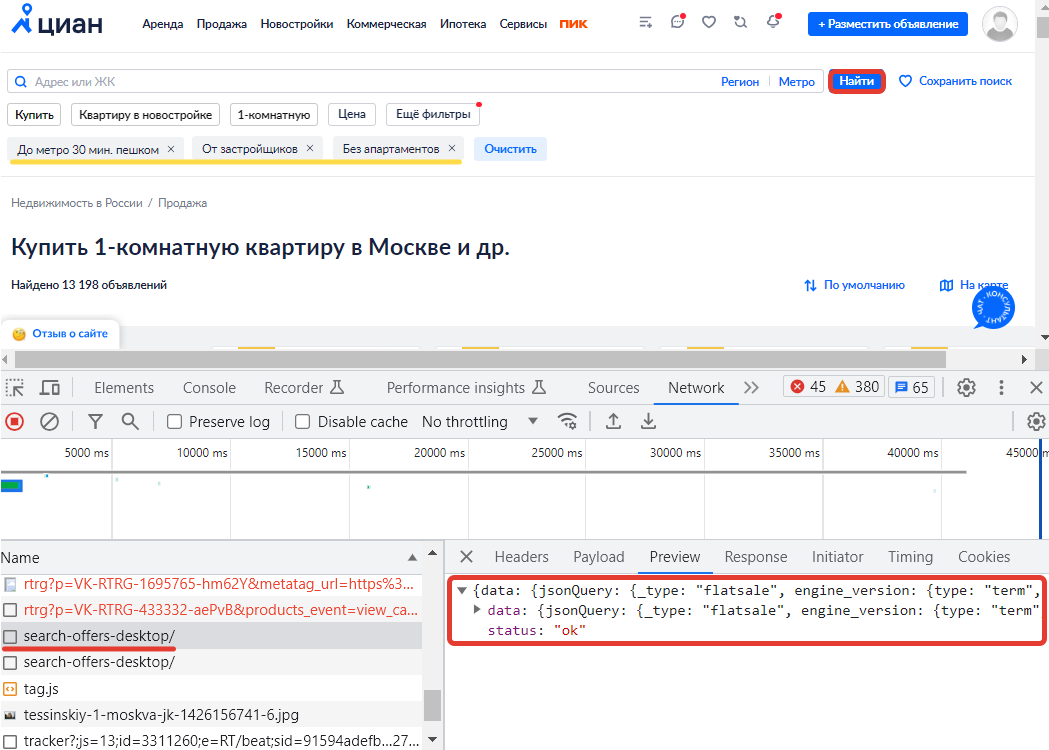

Эти данные и будем получать Парсером. Для этого получим код к данной команде

 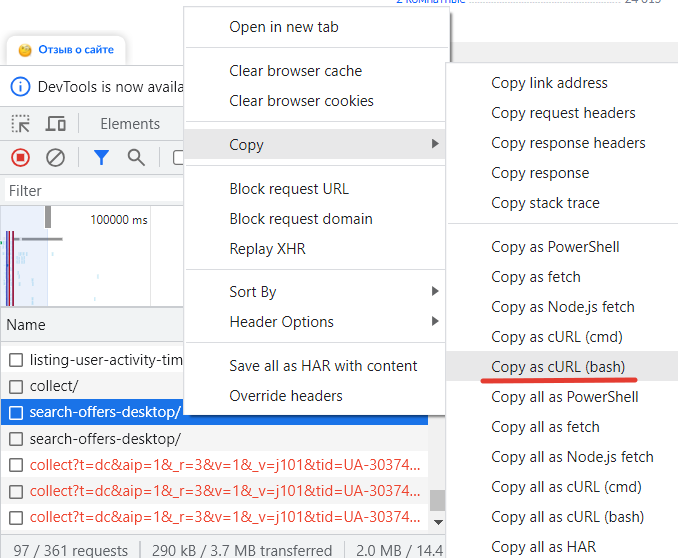

C помощью сервиса https://curlconverter.com/ сконвертируем cURL команду в код Python. И возьмем его за основу парсера. Далее напишем функцию с этим кодом.

Оказалось, что CIAN банит Google Colab, поэтому код запустил локально в MS Visual Studio и сохранил в VS датафрейм.

Ниже код для запуска в MS Visual Studio

In [51]:
# загрузка библиотек

!pip install selenium

import os
import requests
import pandas as pd
import json
import random
from datetime import datetime
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains

In [ ]:
# функция скачивания json файла написанная на основе cURL команды и конвертации в Python

# команда search-offers-desktop запускается при переходе на каждую новую страницу сайта используя json запрос с разницей в номере страницы
# добавим в функцию номер страницы

def get_json(page_number):
    headers = {
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36',
    }
    json_data = {
        'jsonQuery': {
            '_type': 'flatsale',
            'engine_version': {
                'type': 'term',
                'value': 2,
            },
            'region': {
                'type': 'terms',
                'value': [
                    1,
                    4593,
                ],
            },
            'foot_min': {
                'type': 'range',
                'value': {
                    'lte': 30,
                },
            },
            'only_foot': {
                'type': 'term',
                'value': '2',
            },
            'room': {
                'type': 'terms',
                'value': [
                    1, # где 1-3 это число комнат, для студии - число 9
                ],
            },
            'building_status': {
                'type': 'term',
                'value': 2,
            },
            'only_flat': {
                'type': 'term',
                'value': True,
            },
            'from_developer': {
                'type': 'term',
                'value': True,
            },
            'page': {
                'type': 'term',
                'value': page_number, # изменяемый параметр в зависимости от открытой страницы
            },
        },
    }
    response = requests.post(
        'https://api.cian.ru/search-offers/v2/search-offers-desktop/',
        headers=headers,
        json=json_data,
    )
    json_data = response.json()
    return json_data

Для скачивания данных со всех страниц, будем проходиться по страницам используя библиотеку Selenium и скачивать при помощи функции ***get_json*** значения с ***search-offers-desktop*** для каждой открытой страницы

In [ ]:
# инициализация драйвера браузера

# путь к драйверу Chrome
webdriver_service = Service('C:\\Windows\\chromedriver.exe')

# создание нового экземпляра драйвера Chrome
options = webdriver.ChromeOptions()
options.add_argument("user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36")
options.add_argument("--disable-blink-features")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--disable-plugins-discovery")

driver = webdriver.Chrome(service=webdriver_service, options=options)
driver.set_window_size(1366, 768)  # установка размеров окна браузера

# открытие страницы.
# указываем ссылку на страницу поиска. В зависимости от 1-комн, 2-комн. квартиры и т.д., ссылка будет разная
driver.get('https://www.cian.ru/cat.php?deal_type=sale&engine_version=2&foot_min=30&from_developer=1&object_type%5B0%5D=2&offer_type=flat&only_flat=1&only_foot=2&region=-1&room1=1')

data = []  # список для хранения данных
error_pages = []  # список для хранения страниц с ошибками

# количество скачанных страниц ЦИАН
# фильтр Циана не дает скачать более 1500 данных и ограничивает поиск всегда на 54-55 странице, поэтому ограничим число страниц 55
num_pages = 55

for i in range(num_pages):
    try:
        element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//span[contains(text(), 'Дальше')]")) # ищем кнопку "Дальше", которая запускает search-offers-desktop
        )

        if element is None:
            print(f"No more pages found after page {i}. Stopping...")
            break

        # вызов функции get_json() для скрапинга данных
        offers = get_json(i+1)
        data.extend(offers.get('data', {}).get('offersSerialized', []))

        print(f"Страница скачана: {i+1}")

        next_button = driver.find_element(By.XPATH, "//span[contains(text(), 'Дальше')]")
        driver.execute_script("arguments[0].scrollIntoView(true);", next_button)
        time.sleep(1)

        driver.execute_script("arguments[0].click();", next_button)

        time.sleep(random.uniform(3,8)) # сделаем рандомное время паузы

    except Exception as e:
        error_pages.append(i + 1)
        continue

# закрытие браузера
driver.quit()

# сохранение данных без ошибок в JSON-файл
filepath = "D:/Docs/Python/cian_df/data.json"

data_without_errors = [data[i] for i in range(len(data)) if i not in error_pages]

with open(filepath, 'w') as json_file:
    json.dump(data_without_errors, json_file)

Полученный таким образом JSON файл представляет собой мешанину в одну строку, которую невозможно использовать. Поэтому необходимо написать функцию для сборки признаков необходимых для датасета и игнорирования тех признаков, которые не нужны

In [ ]:
# функция для сборки необходимых признаков для датасета
# оставим только необходимые признаки

def get_offer(item):

    offer = {}
    offer["url"] = item["fullUrl"] # ссылка на сайт
    offer["offer_id"] = item["id"] # номер объявления
    offer["address"] = item["geo"]["userInput"] # адресс

    # изменим дату объявления, чтобы год был в начале
    timestamp = datetime.fromtimestamp(item["addedTimestamp"])
    timestamp = datetime.strftime(timestamp, '%Y-%m-%d %H:%M:%S')
    offer["offer_date"] = timestamp # дата публикации

    # соберем признаки объявления
    offer["price"] = item["bargainTerms"]["priceRur"] # цена
    offer["area"] = item["totalArea"] # общая площадь
    offer["rooms"] = item["roomsCount"] # число комнат

    # дата окончания строительства
    # дата окончания строительства есть не у всех значений
    if item.get("building") and item["building"].get("deadline") and item["building"]["deadline"].get("quarterEnd"):
        offer["release_date"] = item["building"]["deadline"]["quarterEnd"]
    # если есть только год, то дата окончания будет "год"+середина года (2 июля)
    elif item.get("building") and item["building"].get("deadline") and item["building"]["deadline"].get("year"):
        year = item["building"]["deadline"]["year"]
        offer["release_date"] = f"{year}-07-02"
    # если года нет, то напишем "no data"
    else:
        offer["release_date"] = "no data"  # значение по умолчанию, если нет данных о дедлайне

    # материал стен
    offer["materialType"] = item["building"]["materialType"]

    # отделка квартиры
    # для тех квартир у кого не прописана отделка напишем "без отделки"
    if item.get("decoration") is None:
       offer["decoration"] = "without"
    else:
        offer["decoration"] = item["decoration"]

    # этажи
    offer["floor"] = item["floorNumber"] # номер этажа
    offer["total_floor"] = item["building"]["floorsCount"] # общее число этажей

    # паркинг
    if "building" in item and item["building"].get("parking") is not None:
        offer["parking"] = item["building"]["parking"]["type"]
    else:
        offer["parking"] = "no parking" # значение по умолчанию, если нет данных о паркинге


    # географические координты
    offer["geo_longitude"] = item["geo"]["coordinates"]["lng"] # долгота
    offer["geo_latitude"] = item["geo"]["coordinates"]["lat"] # широта


    # id станции метро и время пешком до него
    for i, underground in enumerate(item["geo"]["undergrounds"]):

        # оcтавим только расстояние пешком до метро
        if underground["transportType"] == "walk":
            underground_id = underground["id"]
            time = underground["time"]

            # оcтавим 2 столбца с ближайшими метро пешком и временем до него
            if i == 0:
                offer["metro_1_id"] = underground_id
                offer["time_to_metro_1"] = time
            elif i == 1:
                offer["metro_2_id"] = underground_id
                offer["time_to_metro_2"] = time
            else:
                break

    return offer



def get_offers(data):
    # Создание пустого DataFrame
    offers_df = pd.DataFrame()

    for item in data:
        offer = get_offer(item)
        # Добавление предложения в DataFrame
        offer_df = pd.DataFrame([offer])  # преобразование словаря в DataFrame
        offers_df = pd.concat([offers_df, offer_df], ignore_index=True)

    return offers_df



df = get_offers(data_without_errors)

# сохраним df в csv-файл для дальнейшего использования:
df.to_csv(r"D:\Docs\Python\cian_df\cian_data.csv", index=False)

Результатом работы парсера будут датасеты для 1-комн., 2-комн., 3-комн. квартир и студий

## Загрузка датафреймов

Выложил датасеты на гуглдиск

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/MyDrive/CIAN_DF"  #  путь до папки
files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]  # список всех CSV файлов

df_list = []  # создаем пустой список для хранения данных из каждого файла

for file in files:
    data = pd.read_csv(os.path.join(folder_path, file))  # читаем данные из каждого файла
    df_list.append(data)  # добавляем данные в список

# объединяем все датафреймы в один
cian_df = pd.concat(df_list)

In [4]:
# размер датафрейма

cian_df.shape

(8812, 19)

# Первичное исследование данных

In [5]:
cian_df.head(10) #первые 10 строк датасета

,url,offer_id,address,offer_date,price,area,rooms,release_date,materialType,decoration,floor,total_floor,parking,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2
0,https://www.cian.ru/sale/flat/297972135/,297972135,"Москва, Ильинка",2024-03-25 02:06:14,111280000,47.50,NaN,2024-12-31,monolith,without,2,5,no parking,37.623509,55.755201,96.0,3.0,125.0,6.0
1,https://www.cian.ru/sale/flat/299093647/,299093647,"Москва, Дубининская улица, 59к6",2024-03-25 12:06:35,18933683,23.80,NaN,2024-07-02,NaN,without,25,27,no parking,37.635652,55.717862,114.0,18.0,85.0,20.0
2,https://www.cian.ru/sale/flat/296836631/,296836631,"Москва, улица Мнёвники",2024-03-25 02:05:26,16238108,22.78,NaN,2027-12-31,monolith,without,24,54,underground,37.507742,55.774190,97.0,14.0,351.0,15.0
3,https://www.cian.ru/sale/flat/291757223/,291757223,"Москва, 2-я Хуторская улица",2024-03-25 02:05:24,15371236,26.38,NaN,2025-06-30,monolith,without,17,43,underground,37.571806,55.806157,37.0,6.0,424.0,18.0
4,https://www.cian.ru/sale/flat/299262114/,299262114,"Москва, Западный административный округ, район...",2024-03-25 02:13:28,16770000,27.00,NaN,2023-06-30,monolith,without,9,14,no parking,37.496489,55.715036,NaN,NaN,NaN,NaN
5,https://www.cian.ru/sale/flat/299905958/,299905958,"Москва, жилой комплекс Эвер, 3",2024-03-25 15:01:36,17309160,29.70,NaN,2023-12-31,monolith,without,15,34,no parking,37.531103,55.659129,42.0,11.0,390.0,11.0
6,https://www.cian.ru/sale/flat/299132311/,299132311,"Москва, Нагатинская улица, к3вл1",2024-03-22 02:14:23,13999724,19.74,NaN,2025-06-30,NaN,without,7,25,underground,37.627768,55.682326,73.0,6.0,307.0,18.0
7,https://www.cian.ru/sale/flat/296523633/,296523633,"Москва, Северный административный округ, район...",2024-03-25 13:10:48,21622070,28.90,NaN,2027-06-30,monolith,without,3,36,underground,37.582631,55.780854,15.0,5.0,68.0,18.0
8,https://www.cian.ru/sale/flat/291114396/,291114396,"Москва, Северо-Восточный административный окру...",2024-03-25 02:13:08,15790600,27.40,NaN,2025-07-02,monolithBrick,without,2,24,no parking,37.641340,55.838497,21.0,10.0,276.0,18.0
9,https://www.cian.ru/sale/flat/299023685/,299023685,"Москва, Лётная улица",2024-03-25 02:13:59,12654706,23.40,NaN,2025-07-02,monolithBrick,without,10,22,underground,37.420607,55.820382,133.0,12.0,275.0,13.0


In [6]:
cian_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8812 entries, 0 to 152
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              8812 non-null   object 
 1   offer_id         8812 non-null   int64  
 2   address          8812 non-null   object 
 3   offer_date       8812 non-null   object 
 4   price            8812 non-null   int64  
 5   area             8812 non-null   float64
 6   rooms            7514 non-null   float64
 7   release_date     8812 non-null   object 
 8   materialType     8665 non-null   object 
 9   decoration       8812 non-null   object 
 10  floor            8812 non-null   int64  
 11  total_floor      8812 non-null   int64  
 12  parking          8812 non-null   object 
 13  geo_longitude    8812 non-null   float64
 14  geo_latitude     8812 non-null   float64
 15  metro_1_id       6791 non-null   float64
 16  time_to_metro_1  6791 non-null   float64
 17  metro_2_id     

In [7]:
cian_df.isnull().sum() #проверка на пропуски

url                   0
offer_id              0
address               0
offer_date            0
price                 0
area                  0
rooms              1298
release_date          0
materialType        147
decoration            0
floor                 0
total_floor           0
parking               0
geo_longitude         0
geo_latitude          0
metro_1_id         2021
time_to_metro_1    2021
metro_2_id         5355
time_to_metro_2    5355
dtype: int64

Видим, что имеются пропуски в числе комнат и в станциях метро. Выведем эти строки

In [8]:
null_data = cian_df[cian_df.isnull().any(axis=1)]
null_data

,url,offer_id,address,offer_date,price,area,rooms,release_date,materialType,decoration,floor,total_floor,parking,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2
0,https://www.cian.ru/sale/flat/297972135/,297972135,"Москва, Ильинка",2024-03-25 02:06:14,111280000,47.50,NaN,2024-12-31,monolith,without,2,5,no parking,37.623509,55.755201,96.0,3.0,125.0,6.0
1,https://www.cian.ru/sale/flat/299093647/,299093647,"Москва, Дубининская улица, 59к6",2024-03-25 12:06:35,18933683,23.80,NaN,2024-07-02,NaN,without,25,27,no parking,37.635652,55.717862,114.0,18.0,85.0,20.0
2,https://www.cian.ru/sale/flat/296836631/,296836631,"Москва, улица Мнёвники",2024-03-25 02:05:26,16238108,22.78,NaN,2027-12-31,monolith,without,24,54,underground,37.507742,55.774190,97.0,14.0,351.0,15.0
3,https://www.cian.ru/sale/flat/291757223/,291757223,"Москва, 2-я Хуторская улица",2024-03-25 02:05:24,15371236,26.38,NaN,2025-06-30,monolith,without,17,43,underground,37.571806,55.806157,37.0,6.0,424.0,18.0
4,https://www.cian.ru/sale/flat/299262114/,299262114,"Москва, Западный административный округ, район...",2024-03-25 02:13:28,16770000,27.00,NaN,2023-06-30,monolith,without,9,14,no parking,37.496489,55.715036,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,https://www.cian.ru/sale/flat/299511511/,299511511,"Москва, Северо-Восточный административный окру...",2024-03-22 14:09:27,8526882,29.40,NaN,2025-06-30,monolith,preFine,10,33,no parking,37.581495,55.872648,NaN,NaN,NaN,NaN
149,https://www.cian.ru/sale/flat/299511376/,299511376,"Москва, Северо-Восточный административный окру...",2024-03-22 13:48:13,8599486,29.70,NaN,2025-06-30,monolith,preFine,27,33,no parking,37.581495,55.872648,NaN,NaN,NaN,NaN
150,https://www.cian.ru/sale/flat/299511344/,299511344,"Москва, Северо-Восточный административный окру...",2024-03-22 13:48:10,7309114,22.30,NaN,2025-06-30,monolith,preFine,28,33,no parking,37.581495,55.872648,NaN,NaN,NaN,NaN
151,https://www.cian.ru/sale/flat/299511505/,299511505,"Москва, Северо-Восточный административный окру...",2024-03-22 14:39:07,7801128,24.00,NaN,2025-06-30,monolith,preFine,9,33,no parking,37.581495,55.872648,NaN,NaN,NaN,NaN


Видим, что значение "rooms" - равное NaN соотвествует студиям, а NaN в метро возникает тогда, когда у 2-х станций метро расстояние не было указано пешком. При сборке датафрейма оставил только 2 станции метро, которые в большинстве случаев были ближайшие и игнорировал 3 станцию метро, где обычно указывалось расстояние на авто

Пропишем в студиях для признака "rooms" значение "0"

In [9]:
cian_df['rooms'] = cian_df['rooms'].fillna(value = 0)

In [10]:
cian_df.isnull().sum() #снова проверим на пропуски

url                   0
offer_id              0
address               0
offer_date            0
price                 0
area                  0
rooms                 0
release_date          0
materialType        147
decoration            0
floor                 0
total_floor           0
parking               0
geo_longitude         0
geo_latitude          0
metro_1_id         2021
time_to_metro_1    2021
metro_2_id         5355
time_to_metro_2    5355
dtype: int64

Видим, что теперь пропуски в rooms отсутствуют

Удалим элементы, у которых признак materialType принимают значение NaN

In [11]:
# удалим эти элементы
cian_df = cian_df.dropna(subset=['materialType'], how='all')

Выведем элементы, у которых оба признака metro_1_id и metro_2_id принимают значение NaN

In [12]:
# фильтрация строк, где оба значения принимают NaN
cian_df.loc[(cian_df['metro_1_id'].isna()) & (cian_df['metro_2_id'].isna())].shape

(1990, 19)

In [13]:
# удалим эти элементы
cian_df = cian_df.dropna(subset=['metro_1_id', 'metro_2_id'], how='all')
# также удалим элементы, в которых NaN встречается в 'metro_1_id'
cian_df = cian_df.dropna(subset=['metro_1_id'], how='all')

In [14]:
cian_df.isnull().sum() #снова проверим на пропуски

url                   0
offer_id              0
address               0
offer_date            0
price                 0
area                  0
rooms                 0
release_date          0
materialType          0
decoration            0
floor                 0
total_floor           0
parking               0
geo_longitude         0
geo_latitude          0
metro_1_id            0
time_to_metro_1       0
metro_2_id         3278
time_to_metro_2    3278
dtype: int64

Видим, что теперь пустые значения остались только в признаке ***metro_2_id ***

In [15]:
cian_df[cian_df.duplicated()] #проверим наличие дубликатов

,url,offer_id,address,offer_date,price,area,rooms,release_date,materialType,decoration,floor,total_floor,parking,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2
425,https://www.cian.ru/sale/flat/298525604/,298525604,"Москва, Западный административный округ, район...",2024-03-23 22:50:59,8665972,23.9,0.0,2025-12-31,monolithBrick,without,24,24,no parking,37.382341,55.644210,532.0,9.0,364.0,17.0
428,https://www.cian.ru/sale/flat/298814458/,298814458,"Москва, жилой комплекс Плеханова 11, к1.4",2024-03-25 02:50:22,8771216,19.4,0.0,2026-09-30,monolith,fine,20,24,open,37.763062,55.752675,152.0,13.0,NaN,NaN
435,https://www.cian.ru/sale/flat/296791021/,296791021,"Москва, жилой комплекс Плеханова 11, к1.4",2024-03-25 02:49:42,8934498,19.9,0.0,2026-09-30,monolith,fine,23,24,open,37.763062,55.752675,152.0,13.0,NaN,NaN
449,https://www.cian.ru/sale/flat/289992390/,289992390,"Москва, поселение Сосенское, улица Александры ...",2024-03-25 16:01:46,9122927,23.3,0.0,2026-06-30,monolith,without,16,16,no parking,37.475399,55.552712,380.0,13.0,NaN,NaN
458,https://www.cian.ru/sale/flat/298380600/,298380600,"Москва, Южнопортовая улица",2024-03-25 12:41:38,9188059,18.4,0.0,2025-12-31,monolith,without,2,24,no parking,37.696148,55.704945,48.0,14.0,305.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,https://www.cian.ru/sale/flat/299066867/,299066867,"Москва, Ленинский проспект, 38",2024-03-21 21:14:01,165232000,179.6,3.0,2023-12-31,monolithBrick,preFine,17,17,underground,37.572177,55.704450,63.0,14.0,NaN,NaN
496,https://www.cian.ru/sale/flat/299066863/,299066863,"Москва, Ленинский проспект, 38",2024-03-21 21:13:58,171302000,176.6,3.0,2023-12-31,monolithBrick,preFine,17,17,underground,37.572177,55.704450,63.0,14.0,NaN,NaN
498,https://www.cian.ru/sale/flat/299233236/,299233236,"Москва, Ленинградский проспект, 37/7",2024-03-22 21:08:53,183560639,163.5,3.0,2023-06-30,monolith,preFine,37,41,underground,37.543145,55.793752,9.0,12.0,36.0,12.0
499,https://www.cian.ru/sale/flat/299066866/,299066866,"Москва, Ленинский проспект, 38",2024-03-21 21:13:53,219555000,209.1,3.0,2023-12-31,monolithBrick,preFine,17,17,underground,37.572177,55.704450,63.0,14.0,NaN,NaN


Видим, что имеются дубликаты, удалим их

In [16]:
cian_df.drop_duplicates(inplace=True) #удалим дубликаты

In [17]:
cian_df.shape

(5162, 19)

In [18]:
cian_df.describe()

,offer_id,price,area,rooms,floor,total_floor,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2
count,5.162000e+03,5.162000e+03,5162.000000,5162.000000,5162.000000,5162.000000,5162.000000,5162.000000,5162.000000,5162.000000,2606.000000,2606.000000
mean,2.948525e+08,2.616022e+07,54.619132,1.605579,14.203022,29.231693,37.571545,55.743695,229.387834,11.164471,240.395242,14.986569
std,6.312519e+06,3.414655e+07,26.244869,1.106336,11.012343,13.187475,0.126924,0.085658,162.620319,4.600602,154.005859,3.621143
min,2.433008e+08,4.698927e+06,15.700000,0.000000,1.000000,3.000000,37.208345,55.512641,1.000000,1.000000,2.000000,1.000000
25%,2.932028e+08,1.392609e+07,35.600000,1.000000,4.000000,21.000000,37.478975,55.686234,69.000000,8.000000,81.000000,12.000000
50%,2.968832e+08,1.902219e+07,46.615000,1.000000,12.000000,27.000000,37.570311,55.744162,282.000000,11.000000,289.000000,15.000000
75%,2.992564e+08,2.802423e+07,72.100000,3.000000,21.000000,33.000000,37.645681,55.814335,380.000000,14.000000,369.000000,18.000000
max,3.000285e+08,6.846200e+08,300.100000,3.000000,68.000000,85.000000,37.943374,55.944885,560.000000,20.000000,521.000000,20.000000


# EDA. Разведочный анализ данных

In [19]:
#Загрузка библиотек

import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle


# модули библиотеки PyTorch
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

Выведем соотношение квартир по числу спален

Text(0, 0.5, 'Число')

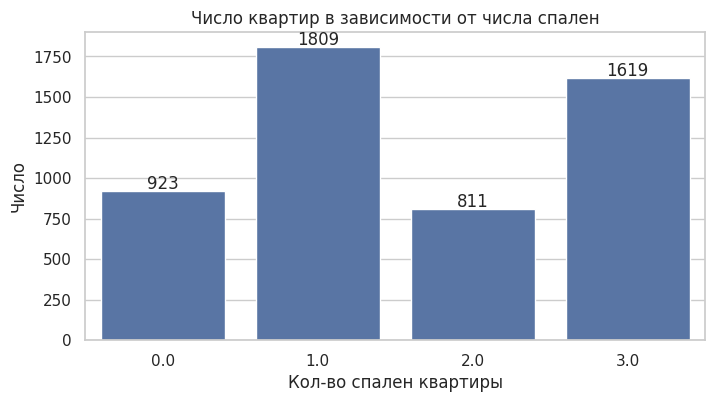

In [20]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,4))

ax = sns.countplot(x = cian_df['rooms'], data = cian_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Число квартир в зависимости от числа спален')
plt.xlabel('Кол-во спален квартиры')
plt.ylabel('Число')

Выведем соотношение квартир по типу отделки

Text(0, 0.5, 'Число')

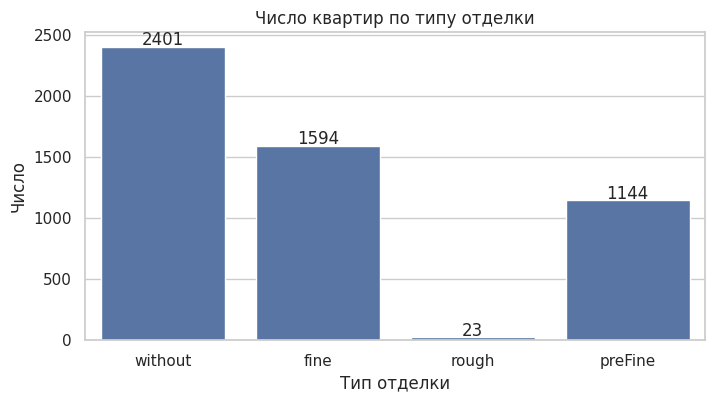

In [21]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,4))

ax = sns.countplot(x = cian_df['decoration'], data = cian_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Число квартир по типу отделки')
plt.xlabel('Тип отделки')
plt.ylabel('Число')

Видим, что кроме основных классов ***fine***, ***preFine*** и ***without*** имеется и непопулярный класс ***rough***. Переназовем ***rough*** в ***without***

In [22]:
cian_df['decoration'] = cian_df['decoration'].replace('rough', 'without')

In [23]:
# выведем число элементов каждого класса

print(cian_df['decoration'].value_counts())

without    2424
fine       1594
preFine    1144
Name: decoration, dtype: int64


Видим, что число элементов с признаком "without" выросло

Выведем долю квартир в зависимости от материала стен

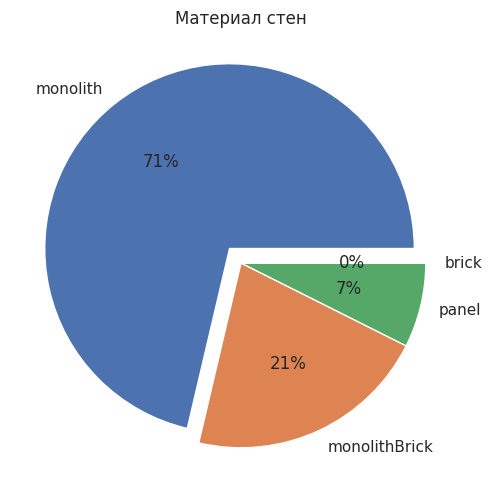

In [24]:
plt.figure(figsize=(6,6))

# число категорий
n_categories = len(cian_df['materialType'].value_counts().index)

myexplode = [0.1] + [0]*(n_categories-1)

plt.pie(x=cian_df['materialType'].value_counts().values,
    labels=cian_df['materialType'].value_counts().index,
    autopct='%.0f%%',explode=myexplode)

plt.title('Материал стен')

plt.show()

Выведем долю квартир в зависимости от типа паркинга

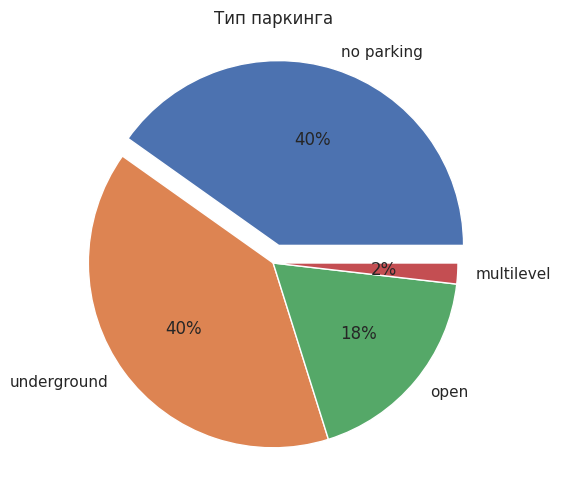

In [25]:
plt.figure(figsize=(6,6))

# число категорий
n_categories = len(cian_df['parking'].value_counts().index)

myexplode = [0.1] + [0]*(n_categories-1)

plt.pie(x=cian_df['parking'].value_counts().values,
    labels=cian_df['parking'].value_counts().index,
    autopct='%.0f%%',explode=myexplode)

plt.title('Тип паркинга')

plt.show()

Для последующего анализа нам потребуется показатель стоимости 1 квадратного метра жилья. Создадим признак "price_1sq m"

In [26]:
cian_df["price_1sq m"] = cian_df["price"] / cian_df["area"]
cian_df.head(5)

,url,offer_id,address,offer_date,price,area,rooms,release_date,materialType,decoration,floor,total_floor,parking,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2,price_1sq m
0,https://www.cian.ru/sale/flat/297972135/,297972135,"Москва, Ильинка",2024-03-25 02:06:14,111280000,47.50,0.0,2024-12-31,monolith,without,2,5,no parking,37.623509,55.755201,96.0,3.0,125.0,6.0,2.342737e+06
2,https://www.cian.ru/sale/flat/296836631/,296836631,"Москва, улица Мнёвники",2024-03-25 02:05:26,16238108,22.78,0.0,2027-12-31,monolith,without,24,54,underground,37.507742,55.774190,97.0,14.0,351.0,15.0,7.128230e+05
3,https://www.cian.ru/sale/flat/291757223/,291757223,"Москва, 2-я Хуторская улица",2024-03-25 02:05:24,15371236,26.38,0.0,2025-06-30,monolith,without,17,43,underground,37.571806,55.806157,37.0,6.0,424.0,18.0,5.826852e+05
5,https://www.cian.ru/sale/flat/299905958/,299905958,"Москва, жилой комплекс Эвер, 3",2024-03-25 15:01:36,17309160,29.70,0.0,2023-12-31,monolith,without,15,34,no parking,37.531103,55.659129,42.0,11.0,390.0,11.0,5.828000e+05
7,https://www.cian.ru/sale/flat/296523633/,296523633,"Москва, Северный административный округ, район...",2024-03-25 13:10:48,21622070,28.90,0.0,2027-06-30,monolith,without,3,36,underground,37.582631,55.780854,15.0,5.0,68.0,18.0,7.481685e+05


Выведем зависимость стоимости 1 квадратного метра жилья от показателей: "материал стены", "тип отделки" и "тип паркинга"

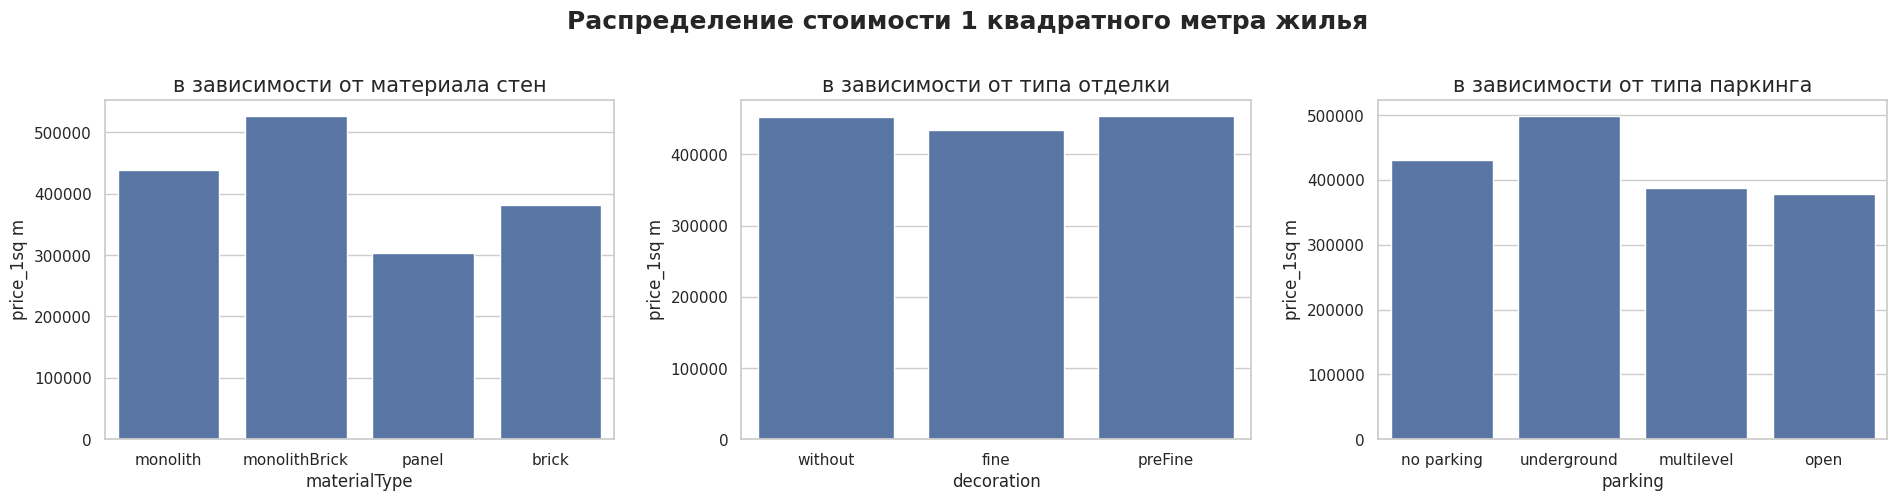

In [27]:
fig = plt.figure(figsize=(23,15))
gs  = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle(t='Распределение стоимости 1 квадратного метра жилья',y=0.94, fontweight ="bold",fontsize=18)

# в зависимости от материала стен
ax1.set_title('в зависимости от материала стен',fontsize=15)
ax1.grid(color='#000000', linestyle='dashed', axis='x',dashes=(1,9))
sns.barplot(ax=ax1,data=cian_df,x='materialType', y='price_1sq m', errorbar=None)

# в зависимости от типа отделки
ax2.set_title('в зависимости от типа отделки',fontsize=15)
ax2.grid(color='#000000', linestyle='dashed', axis='x',dashes=(1,9))
sns.barplot(ax=ax2,data=cian_df,x='decoration', y='price_1sq m', errorbar=None)

# в зависимости от типа паркинга
ax3.set_title('в зависимости от типа паркинга',fontsize=15)
ax3.grid(color='#000000', linestyle='dashed', axis='x',dashes=(1,9))
sns.barplot(ax=ax3,data=cian_df,x='parking', y='price_1sq m', errorbar=None)

# увеличим расстояние между графиками
plt.subplots_adjust(wspace=0.25)

plt.show()

Как видно из графиков, материал стен влияет на стоимость жилья. Дороже всего жилье в монолитно-кирпичном доме, дешевле в панельном.

Зависимость от отделки уже обратная, но это связано с тем, что квартиры с отделкой чаще всего продаются в эконом-классе. В бизнес-классе обычно квартиры совсем без отделки, либо "preFine" (white box)

Наличие подземного или многоуровневого надземного паркинга увеличивает стоимость квадратного метра жилья

Выведем зависимость стоимости 1 квадратного метра жилья от показателей: "дата сдачи", "расстояние до ближайшего метро" для квартир каждой комнантности

<ipython-input-28-1486f6599798>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


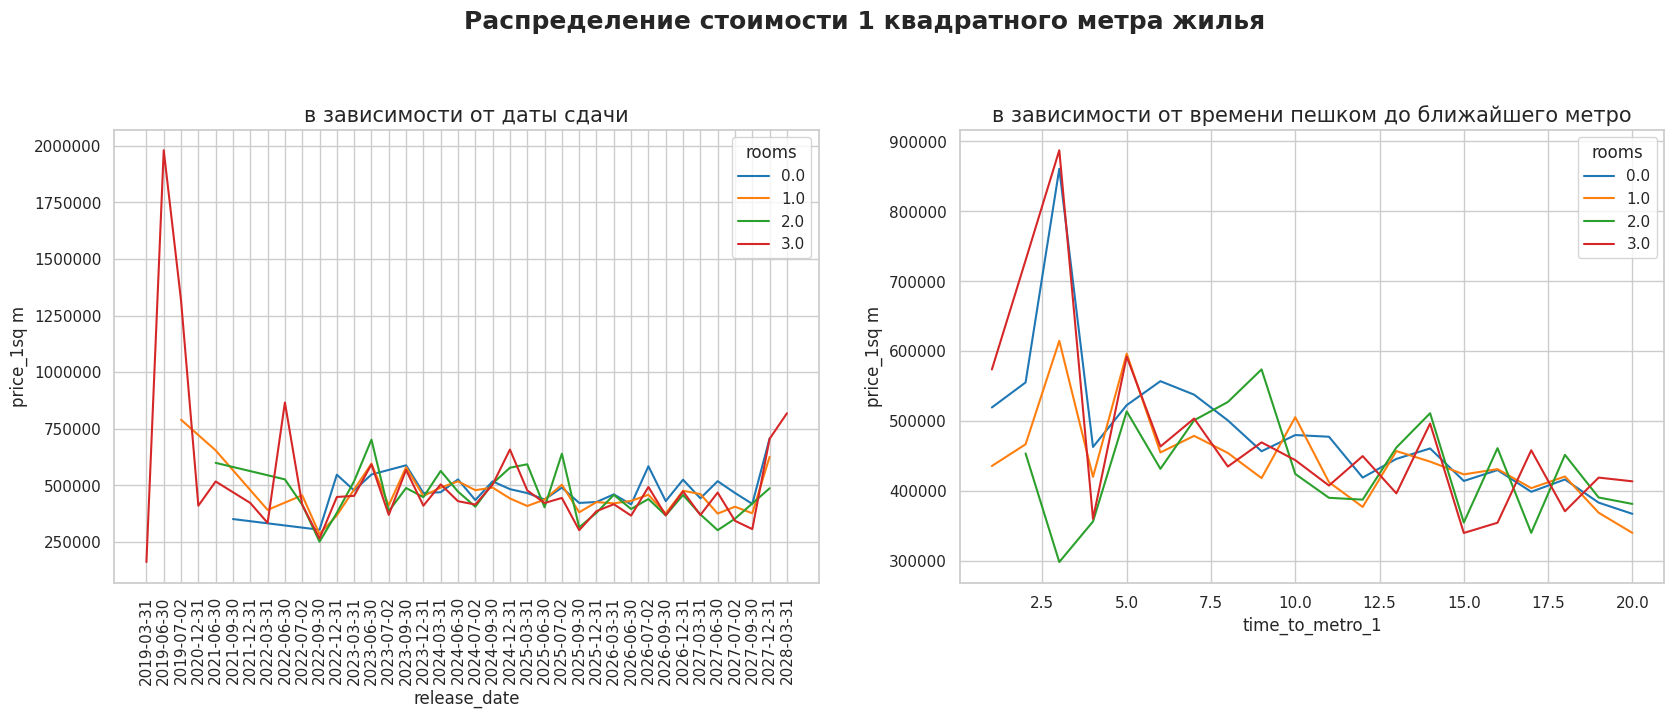

In [28]:
fig = plt.figure(figsize=(20,20))
gs  = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle(t='Распределение стоимости 1 квадратного метра жилья',y=0.94, fontweight ="bold",fontsize=18)

# в зависимости от даты сдачи
# отсортируем датафрейм по дате

sortedDate_df = cian_df.sort_values('release_date')
ax1.set_title('в зависимости от даты сдачи',fontsize=15)
sns.lineplot(ax=ax1,data=sortedDate_df,x='release_date', y='price_1sq m', hue= 'rooms', errorbar=None, palette = 'tab10')
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# в зависимости от времени пешком до ближайшего метро
ax2.set_title('в зависимости от времени пешком до ближайшего метро',fontsize=15)
sns.lineplot(ax=ax2,data=cian_df,x='time_to_metro_1', y='price_1sq m', hue= 'rooms', errorbar=None, palette = 'tab10')

plt.show()

Как видно из графиков, близость к метро сильно влияет на уровень цен. Дата сдачи квартиры тоже влияет, но не так сильно

Составим матрицу корреляций признаков

<ipython-input-29-5cc7cfbb28c8>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cian_df.corr(), square=True)


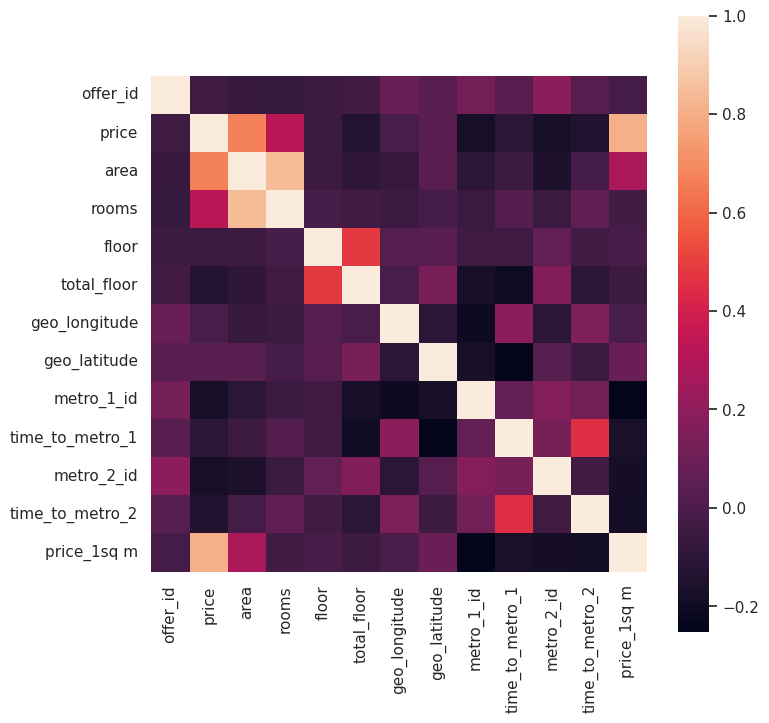

In [29]:
plt.subplots(figsize=(8,8))

sns.heatmap(cian_df.corr(), square=True)
plt.show()

Как видно по тепловой карте, кроме очевидной корреляция между признаками "price", "area", "rooms" имеется и корреляция между координатами, временем до метро и ценой

Сохраним полученный датафрейм на гугл-диск

In [30]:
cian_df.to_csv('/content/drive/My Drive/cian_df.csv', index=False)

# Предобработка

Для категориальных признаков, таких как ***release_date***, ***materialType***, ***decoration*** и  ***parking*** будем использовать энкодинг. Используем OrdinalEncoder


In [31]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
cian_df[['materialType_encoded', 'decoration_encoded', 'parking_encoded']] = oe.fit_transform(cian_df[['materialType', 'decoration', 'parking']])

In [32]:
cian_df.head(5)

,url,offer_id,address,offer_date,price,area,rooms,release_date,materialType,decoration,...,geo_longitude,geo_latitude,metro_1_id,time_to_metro_1,metro_2_id,time_to_metro_2,price_1sq m,materialType_encoded,decoration_encoded,parking_encoded
0,https://www.cian.ru/sale/flat/297972135/,297972135,"Москва, Ильинка",2024-03-25 02:06:14,111280000,47.50,0.0,2024-12-31,monolith,without,...,37.623509,55.755201,96.0,3.0,125.0,6.0,2.342737e+06,1.0,2.0,1.0
2,https://www.cian.ru/sale/flat/296836631/,296836631,"Москва, улица Мнёвники",2024-03-25 02:05:26,16238108,22.78,0.0,2027-12-31,monolith,without,...,37.507742,55.774190,97.0,14.0,351.0,15.0,7.128230e+05,1.0,2.0,3.0
3,https://www.cian.ru/sale/flat/291757223/,291757223,"Москва, 2-я Хуторская улица",2024-03-25 02:05:24,15371236,26.38,0.0,2025-06-30,monolith,without,...,37.571806,55.806157,37.0,6.0,424.0,18.0,5.826852e+05,1.0,2.0,3.0
5,https://www.cian.ru/sale/flat/299905958/,299905958,"Москва, жилой комплекс Эвер, 3",2024-03-25 15:01:36,17309160,29.70,0.0,2023-12-31,monolith,without,...,37.531103,55.659129,42.0,11.0,390.0,11.0,5.828000e+05,1.0,2.0,1.0
7,https://www.cian.ru/sale/flat/296523633/,296523633,"Москва, Северный административный округ, район...",2024-03-25 13:10:48,21622070,28.90,0.0,2027-06-30,monolith,without,...,37.582631,55.780854,15.0,5.0,68.0,18.0,7.481685e+05,1.0,2.0,3.0


Т.к. масштаб данных примерно одинаковый, нет необходимости в нормализации признаков

In [33]:
# удалим неинформативные признаки. признаки до энкодинга и целевой признак "price_1sq m"
X = cian_df.drop(columns = ['url','offer_id', 'offer_date', 'release_date','address','materialType', 'decoration', 'parking','price', 'metro_2_id','time_to_metro_2', 'price_1sq m'])
y = cian_df['price_1sq m']

In [34]:
# Разбиваем матрицу признаков и ответы на обучающую и тестовую выборки в соотношении 80/20. Посмотрим на число строк и столбцов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (4129, 11)
X_test : (1033, 11)
y_train : (4129,)
y_test : (1033,)


# **Алгоритмы**

## Прогнозирование цены квадратного метра

### Linear regression, DecisionTree, RandomForest, XGBoost, KNN, LightGBM

Используем пайплайн для базовых алгоритмов "из коробки"

In [35]:
pipes = [
    Pipeline([('scaler', StandardScaler()), ('Linear', LinearRegression())]),
    Pipeline([('scaler', StandardScaler()), ('DecisionTree', DecisionTreeRegressor())]),
    Pipeline([('scaler', StandardScaler()), ('RandomForest', RandomForestRegressor())]),
    Pipeline([('scaler', StandardScaler()), ('XGBoost', XGBRegressor())]),
    Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsRegressor())]),
    Pipeline([('scaler', StandardScaler()), ('LGBM', LGBMRegressor())])
]

for pipe in pipes:
    pipe.fit(X_train, y_train)

# Evaluating the models on the test set
for i, pipe in enumerate(pipes):
    y_pred = pipe.predict(X_test)
    if i == 0:  # Linear Regression
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"Linear Regression: RMSE = {rmse:.1f}, R2 = {r2:.4f}")
    elif i == 1:  # DecisionTree
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"DecisionTree: RMSE = {rmse:.1f}, R2 = {r2:.4f}")
    elif i == 2:  # RandomForest
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"RandomForest: RMSE = {rmse:.1f}, R2 = {r2:.4f}")
    elif i == 3:  # XGBoost
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"XGBoost: RMSE = {rmse:.1f}, R2 = {r2:.4f}")
    elif i == 4: # KNN
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"KNN: RMSE = {rmse:.1f}, R2 = {r2:.4f}")
    else:  # LGBM
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"LGBM: RMSE = {rmse:.1f}, R2 = {r2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 4129, number of used features: 11
[LightGBM] [Info] Start training from score 448734.084959
Linear Regression: RMSE = 179454.3, R2 = 0.3276
DecisionTree: RMSE = 101537.8, R2 = 0.7847
RandomForest: RMSE = 85643.5, R2 = 0.8469
XGBoost: RMSE = 82253.5, R2 = 0.8587
KNN: RMSE = 94116.6, R2 = 0.8151
LGBM: RMSE = 84861.2, R2 = 0.8496


Мы видим, что лучшие метрики имеет XGBoost. Подберем для него гиперпараметры

### Подбор гиперпараметров для XGBoost

In [36]:
# Зададим сетку - среди каких значений выбирать наилучший параметр.
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.05, 0.10, 0.15],
    'max_depth': [5, 10, 15],
    'alpha': [5, 10, 15],
    'n_estimators': [5, 10, 50, 100]
}

# Creating the classifier
model = XGBRegressor()

In [37]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [5, 10, 15], 'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [5, 10, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-5226368364.492558
{'alpha': 15, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 100}


In [39]:
#обучим модель с лучшими параметрами
best_params = grid_search.best_params_

model_price = XGBRegressor(**best_params)
model_price.fit(X_train, y_train)

XGBRegressor(alpha=15, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [40]:
y_pred = model_price.predict(X_test)

# вычисление RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)

RMSE:  71070.78799407808


### Полносвязная нейронная сеть

In [41]:
# отмасштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# преобразуем данные в тензоры

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1)

In [43]:
# создадим нейронную сеть с использованием Sequential

n_features = X_train.shape[1]
model = nn.Sequential(
    nn.Linear(n_features, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# определим оптимизатор и функцию потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [44]:
#обучим модель

model.train()
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

model.eval()
predictions = []
with torch.no_grad():
    for inputs, targets in test_loader:
        output = model(inputs)
        predictions.append(output.item())

print('RMSE for Neural Network:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE for Neural Network: 194832.26857854327


Видим что XGBost выдает лучшие метрики, чем нейросеть в нашей задаче

## Прогнозирование категориальных признаков **Материал стен** ,**Тип отделки** и **Тип паркинга**

Для определения класса жилья и наполнения жилья в данной локации также полезно получить оценку материала стен, типа отделки и типа паркинга.

Для эконом-класса обычно свойствены панельные или монолитные стены, для более дорогого жилья применяют кирпичные или монолитно-кирпичные стены

Для эконом-класса может оказаться критическим наличие отделки, а в бизнес-классе отделка вероятнее всего будет не нужна. Т.к. в таком жилье покупатели новостроек часто прибегают к услугам дизайнеров по интерьеру и готовы вложить в ремонт дополнительные финансовые средства

Тип паркинга также влияет на класс жилья. В бизнес-классе часто проектируют подземные паркинги. В эконом-классе обычно плоскостные наземные парковки, либо, если площадь участка не достаточна, то многоуровневые надземные паркинги

Создадим 3 отдельные модели на каждый признак, т.к. эти признаки независимы друг от друга, то можем использовать одну и ту же обучающую выборку. Используем модель RandomForestClassifier

In [45]:
# Разделение данных на обучающую и тестовую выборку
X = cian_df.drop(columns=['url','offer_id', 'offer_date', 'release_date','address','materialType', 'decoration', 'parking','price', 'price_1sq m' , 'metro_2_id', 'time_to_metro_2', 'materialType_encoded', 'decoration_encoded', 'parking_encoded'])
y_material = cian_df['materialType']
y_decoration = cian_df['decoration']
y_parking = cian_df['parking']

X_train, X_test, y_material_train, y_material_test = train_test_split(X, y_material, test_size=0.2, random_state=42)
X_train, X_test, y_decoration_train, y_decoration_test = train_test_split(X, y_decoration, test_size=0.2, random_state=42)
X_train, X_test, y_parking_train, y_parking_test = train_test_split(X, y_parking, test_size=0.2, random_state=42)


# Обучение моделей
model_material = RandomForestClassifier()
model_decoration = RandomForestClassifier()
model_parking = RandomForestClassifier()

model_material.fit(X_train, y_material_train)
model_decoration.fit(X_train, y_decoration_train)
model_parking.fit(X_train, y_parking_train)

# Предсказание
y_material_pred = model_material.predict(X_test)
y_decoration_pred = model_decoration.predict(X_test)
y_parking_pred = model_parking.predict(X_test)

# Оценка модели
material_accuracy = accuracy_score(y_material_test, y_material_pred)
decoration_accuracy = accuracy_score(y_decoration_test, y_decoration_pred)
parking_accuracy = accuracy_score(y_parking_test, y_parking_pred)


print(f"Accuracy of material prediction: {material_accuracy}")
print(f"Accuracy of decoration prediction: {decoration_accuracy}")
print(f"Accuracy of parking prediction: {parking_accuracy}")

Accuracy of material prediction: 0.9970958373668926
Accuracy of decoration prediction: 0.718296224588577
Accuracy of parking prediction: 0.9874152952565344


Метрики получились очень хорошие, можно оставить их и без подбора гиперпараметров. В любом случае данные признаки вторичны по отношению к основному признаку "цена 1 кв. м"

## Сохранение обученных моделей на Google диск

Сохраним обученные модели на гуглдиск, для последующего использования

In [46]:
# сохраним модели в файлы

with open('model_price.pkl', 'wb') as file:
    pickle.dump(model_price, file)
with open('model_material.pkl', 'wb') as file:
    pickle.dump(model_material, file)
with open('model_decoration.pkl', 'wb') as file:
    pickle.dump(model_decoration, file)
with open('model_parking.pkl', 'wb') as file:
    pickle.dump(model_parking, file)


In [47]:
# загрузим на гугл диск

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# загрузка файлов на Google Диск
for model_name in ['model_price', 'model_material', 'model_decoration', 'model_parking']:
    model_file = drive.CreateFile({'title' : f"{model_name}.pkl"})
    model_file.SetContentFile(f"{model_name}.pkl")
    model_file.Upload()
    print(f'Uploaded {model_name} to Google Drive')

Uploaded model_price to Google Drive
Uploaded model_material to Google Drive
Uploaded model_decoration to Google Drive
Uploaded model_parking to Google Drive


# Создание веб-приложения

Выложим модель на веб-сервис используя Streamlit

In [48]:
#загрузка библиотек для веб-интерфейса
!pip install streamlit
!pip install streamlit-folium
import streamlit as st
import streamlit_folium as stf
import folium
from streamlit_folium import folium_static
from bs4 import BeautifulSoup


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.0/326.0 kB 5.8 MB/s eta 0:00:00


## Создание словаря станций метро для сайта

Для выпадающего списка из станций метро на сайте нам понадобится словарь, который будет сопостовлять название станции метро и внутренний id номер станции метро циан.

Список id станций и их названия скачал с интернета

In [49]:
# путь к файлу
folder_path = "/content/drive/MyDrive/CIAN_DF"
file_path = os.path.join(folder_path, "metros-moscow-v2.xml")

with open(file_path, 'r') as file:
    content = file.read()

soup = BeautifulSoup(content, 'lxml')


# находим все элементы 'location'
locations = soup.find_all('location')

# преобразуем содержимое в словарь
metro_dict = {}
for location in locations:
    station_name = location.text
    station_id = int(location['id'])
    metro_dict[station_name] = station_id

metro_dict = dict(sorted(metro_dict.items(), key=lambda x: x[0]))
print(metro_dict)

{'Авиамоторная': 472, 'Автозаводская': 2, 'Академическая': 555, 'Александровский сад': 4, 'Алексеевская': 5, 'Алма-Атинская': 245, 'Алтуфьево': 6, 'Аминьевская': 507, 'Андроновка': 473, 'Аникеевка': 416, 'Аннино': 7, 'Апрелевка': 494, 'Арбатская': 8, 'Аэропорт': 9, 'Аэропорт Внуково': 535, 'Бабушкинская': 10, 'Багратионовская': 11, 'Баковка': 405, 'Балтийская': 293, 'Баррикадная': 12, 'Бауманская': 13, 'Бачуринская': 544, 'Беговая': 513, 'Белокаменная': 298, 'Беломорская': 369, 'Белорусская': 514, 'Беляево': 16, 'Бескудниково': 413, 'Бибирево': 17, 'Библиотека им. Ленина': 18, 'Бирюлёво': 564, 'Битца': 433, 'Битцевский парк': 274, 'Борисово': 240, 'Боровицкая': 20, 'Боровское шоссе': 365, 'Ботанический сад': 21, 'Братиславская': 22, 'Бульвар Адмирала Ушакова': 23, 'Бульвар Генерала Карбышева': 558, 'Бульвар Дмитрия Донского': 24, 'Бульвар Рокоссовского': 137, 'Бунинская аллея': 25, 'Бутово': 437, 'Бутырская': 287, 'Быково': 486, 'ВДНХ': 27, 'Вавиловская': 541, 'Варшавская': 26, 'Ватути

<ipython-input-49-3335b3c93a86>:8: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(content, 'lxml')


## Создание Веб-интерфейса

Код ниже разрабатывался в Visual Studio и заливался на виртуальную машину

In [50]:
# загрузка библиотек
!pip install streamlit
!pip install streamlit-folium
import streamlit as st
import streamlit_folium as stf
import folium
from streamlit_folium import folium_static

In [ ]:
# загрузка моделей
with open('model_price.pkl', 'rb') as f:
    model_price = pickle.load(f)

with open('model_material.pkl', 'rb') as f:
    model_material = pickle.load(f)

with open('model_decoration.pkl', 'rb') as f:
    model_decoration = pickle.load(f)

with open('model_parking.pkl', 'rb') as f:
    model_parking = pickle.load(f)


Интерфейс для ввода данных пользователем на сайте

In [ ]:
# ввод данных пользователем на сайте
def user_input_features():

    # пропишем средние площади квартир в зависимости от комнатности, чтобы не вбивать их вручную
    # студия - 25 м2, 1К - 38 м2, 2К - 52 м2, 3К - 66 м2
    rooms_area = {0: 25, 1: 38, 2: 52, 3: 66}

    # для анализа участка застройки примем средние для Москвы показатели этажности
    floor = 12 # середина от max этажности
    total_floor = 25 # примем за среднюю этажность дома 25 этажей

    #для ввода координат будем использовать координаты яндекс карты
    coordinates = st.text_input('Введите координаты (широта, долгота)',
                               value="55.798150, 37.430560").split(',') #формат координат Яндекс-карты
    geo_latitude = float(coordinates[0]) # широта
    geo_longitude = float(coordinates[1]) # долгота

    # проверка введенных координат, на то, что они находятся в пределах границ Москвы (Новую Москву для анализа пока не включал)
    if not 55.600000 <= geo_latitude <= 55.910000 or not 37.300000 <= geo_longitude <= 37.900000:
        st.warning('Координаты находятся за пределами Москвы. Проверьте введенные данные.')
        return None


    # выпадающий список метро
    metro_name = st.selectbox('Выберите ближайшую станцию', list(metro_dict.keys()))
    time_to_metro_1 = st.number_input('Время пешком до метро', min_value=1)

    # соберем введенные данные в датафрейм
    user_data_list = []

    for rooms, area in rooms_area.items():
        user_data = {
            'area': area,
            'rooms': rooms,
            'floor': floor,
            'total_floor': total_floor,
            'geo_longitude': geo_longitude,
            'geo_latitude': geo_latitude,
            'metro_1_id': metro_dict[metro_name],
            'time_to_metro_1': time_to_metro_1
        }
        user_data_list.append(user_data)

    return pd.DataFrame(user_data_list)

Применим сохраненные модели к полученным данным

In [ ]:
# прогноз типа стен, отделки и паркинга
material_prediction = model_material.predict(user_data)
decoration_prediction = model_decoration.predict(user_data)
parking_prediction = model_parking.predict(user_data)

# создание нового датафрейма с предсказанными метками
predicted_df = user_data.copy()
predicted_df['materialType'] = material_prediction
predicted_df['decoration'] = decoration_prediction
predicted_df['parking'] = parking_prediction

# кодирование предсказаний
oe = OrdinalEncoder()

predicted_df[['materialType_encoded', 'decoration_encoded', 'parking_encoded']] = oe.fit_transform(
    predicted_df[['materialType', 'decoration', 'parking']])

# подготовка данных для предсказания цены
price_df = predicted_df.drop(columns = ['materialType','decoration', 'parking'])

# предсказание цены
price_predictions = model_price.predict(price_df)

# предсказывать цену будем для квартир разной комнатности для данной локации
# т.к. стоимость 1 м2 в студиях максимальная, а в 3к квартирам минимальная
room_types = ['студии', '1к квартиры', '2к квартиры', '3к квартиры']

# класс жилья определим на основе данного алгоритма
for room_type, price, material_type, decoration, parking in zip(room_types, price_predictions, material_prediction, decoration_prediction, parking_prediction):
    if price > 800000:
        housing_class = 'Премиум'
    elif 400000 < price < 800000 or (material_type == 'brick' and parking == 'underground'):
        housing_class = 'Бизнес'
    else:
        housing_class = 'Комфорт'

Настроим отображение сайта

In [ ]:
# добавим заголовки
st.title('Оценка участка застройки')
user_data = user_input_features()

# отобразим карту добавим на нее маркер отображения введенных координат
m = folium.Map(location=[user_data['geo_latitude'][0], user_data['geo_longitude'][0]], zoom_start=15)
folium.Marker([user_data['geo_latitude'][0], user_data['geo_longitude'][0]]).add_to(m)
stf.folium_static(m)

# добавим строки для вывода результатов оценки
st.markdown(f'<h4>Класс жилья</h4>', unsafe_allow_html=True)
st.write(housing_class)

st.markdown(f'<h4>Материал стен</h4>', unsafe_allow_html=True)
st.write(material_prediction[0])

st.markdown(f'<h4>Тип отделки</h4>', unsafe_allow_html=True)
st.write(decoration_prediction[0])

st.markdown(f'<h4>Тип паркинга</h4>', unsafe_allow_html=True)
st.write(parking_prediction[0])

for room_type, price in zip(room_types, price_predictions):
    st.markdown(f'<h4>Средняя цена 1 кв. м для {room_type}</h4>', unsafe_allow_html=True)
    st.write(price)

## Загрузка сайта в облако

Для хостинга сайта буду использовать Yandex Cloud. Создал виртуальную машину на которую и выложил код Streamlit

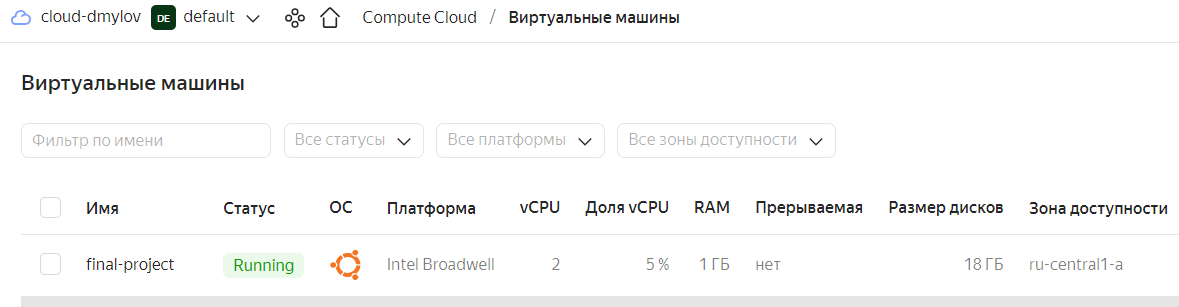

## Работа с сайтом

**[ССЫЛКА НА САЙТ](http://158.160.35.181:8501/)**

К сожалению Streamlit не предоставляет интерактивного взаимодействия с картой. При дальнейшем улучшении модели можно будет прибегнуть к более обширным фреймворкам для того, чтобы на сайте появилась интерактивная карта Яндекс, которая будет по клику мыши высчитывать координаты, ближашую станцию метро и время пешком до нее

Взаимодействие с сайтом построено таким образом,что нужно при помощи стороннего сайта, удобнее всего яндекс-карты, получить координаты

 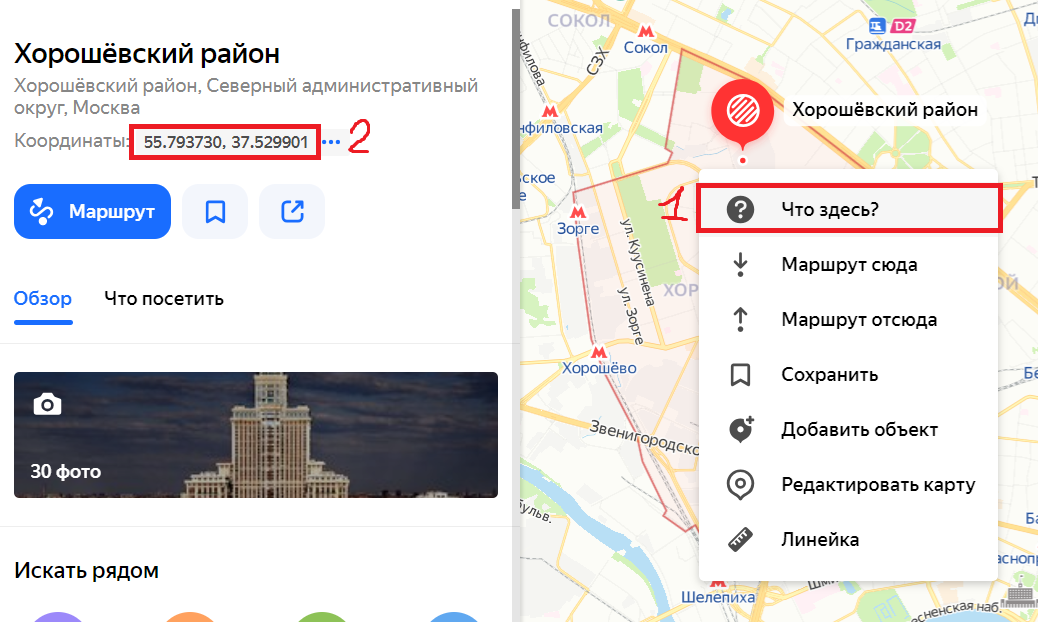

Затем также на яндекс карте находим ближайшую станцию метро, и строим до него маршрут пешком.

Далее заходим на наш сайт [ТЫК](http://158.160.58.55:8502/) и в открывшееся окно копипастим координаты с яндекс-карты, выбираем из выпадающего списка станцию метро и вводим время пешком до него

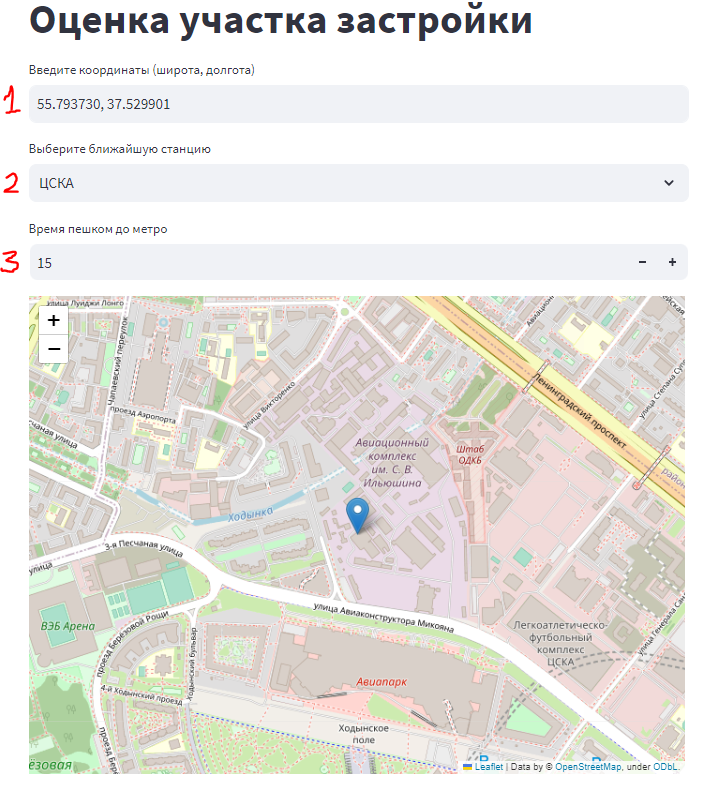

Страница выведет карту с меткой для визуального подтверждения, что координаты ввеедены корректно

На основе введенных данных получаем интересующие нас предсказания:

- Класс жилья (Комфорт/Бизнес/Премиум)
- Материал стен
- Тип отделки (в Премиуме квартиры всегда идут без отделки, в Бизнесе часто без отделки, а в Комфорт(эконом) классе зачастую квартиры идут с отделкой
- Тип паркинга (в Премиуме всегда подземный паркинг, в Бизнесе часто, а для Комфорт класса - это редкость)

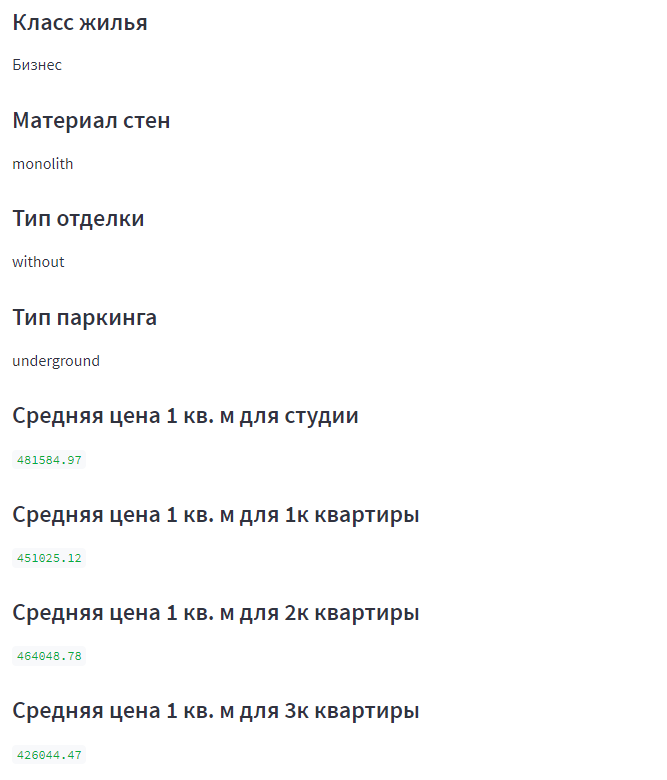

Полученные оценки стоимости жилья идут уже на следующий этап - построение Финансовой модели

[Выложил ролик про модель на Youtube](https://www.youtube.com/watch?v=WS1gQYSPp5Q)



СПАСИБО ЗА ВНИМАНИЕ!